In [169]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from lazypredict.Supervised import LazyClassifier
import lightgbm as lgbm

In [91]:
train_data_og = pd.read_csv('./train.csv')
test_data_og = pd.read_csv('./test.csv')
print(train_data_og.shape, test_data_og.shape)
# print(train_data_og.isnull().sum())
# print(test_data_og.isnull().sum())
print(train_data_og.dtypes)
train_data_og.sample(n=10).style

(8693, 14) (4277, 13)
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
2529,2717_01,Earth,False,G/431/S,TRAPPIST-1e,18.000000,False,130.000000,0.000000,13.000000,191.000000,554.000000,Francy Mayder,False
1409,1490_01,Europa,False,D/47/P,55 Cancri e,26.000000,False,0.000000,304.000000,0.000000,3998.000000,nan,Caphird Crioncery,False
1347,1424_02,Europa,False,B/47/P,55 Cancri e,29.000000,False,2988.000000,2147.000000,0.000000,0.000000,1779.000000,Goros Sageng,False
6919,7337_01,Europa,False,A/89/S,TRAPPIST-1e,25.000000,False,0.000000,115.000000,0.000000,1823.000000,4041.000000,Ranons Folkshbox,False
7948,8487_01,Europa,nan,C/282/P,55 Cancri e,32.000000,True,65.000000,nan,0.000000,88.000000,9811.000000,Kajamak Boderbint,False
2728,2928_01,Europa,False,B/92/P,55 Cancri e,54.000000,True,0.000000,2062.000000,2.000000,19.000000,1618.000000,Menkibi Mander,False
8532,9110_01,Earth,False,F/1866/P,TRAPPIST-1e,47.000000,False,0.000000,0.000000,16.000000,3.000000,854.000000,Ronne Armstromez,False
7138,7609_02,Europa,True,A/83/P,TRAPPIST-1e,39.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Sabiton Reeddommy,True
5278,5631_01,Earth,False,F/1166/P,TRAPPIST-1e,20.000000,False,47.000000,0.000000,0.000000,0.000000,2711.000000,Bel Boltond,False
1494,1585_01,Earth,True,G/252/P,TRAPPIST-1e,18.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,Salley Crosarios,True


# EDA

In [38]:
display(train_data_og.describe(include='all').style)
# print(train_data_og['HomePlanet'].values)
print(f"Transported mean: {train_data_og['Transported'].mean()}")


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,nan,2,nan,nan,nan,nan,nan,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,nan,False,nan,nan,nan,nan,nan,Gollux Reedall,True
freq,1,4602,5439,8,5915,nan,8291,nan,nan,nan,nan,nan,2,4378
mean,nan,nan,nan,nan,nan,28.827930,nan,224.687617,458.077203,173.729169,311.138778,304.854791,nan,nan
std,nan,nan,nan,nan,nan,14.489021,nan,666.717663,1611.489240,604.696458,1136.705535,1145.717189,nan,nan
min,nan,nan,nan,nan,nan,0.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,nan,nan
25%,nan,nan,nan,nan,nan,19.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,nan,nan
50%,nan,nan,nan,nan,nan,27.000000,nan,0.000000,0.000000,0.000000,0.000000,0.000000,nan,nan
75%,nan,nan,nan,nan,nan,38.000000,nan,47.000000,76.000000,27.000000,59.000000,46.000000,nan,nan


Transported mean: 0.5036236051995858


## Checking correlations

In [40]:
display(train_data_og.corr().style)

C:\Users\Dell\AppData\Local\Temp\ipykernel_5224\3671959298.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(train_data_og.corr().style)


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075
Transported,-0.075026,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000


Age has bad correlation with Transported. Others are no good either.   
Maybe making Age bands and clubbing all the prices together might reveal something.

array([[<AxesSubplot: title={'center': 'VRDeck'}>]], dtype=object)

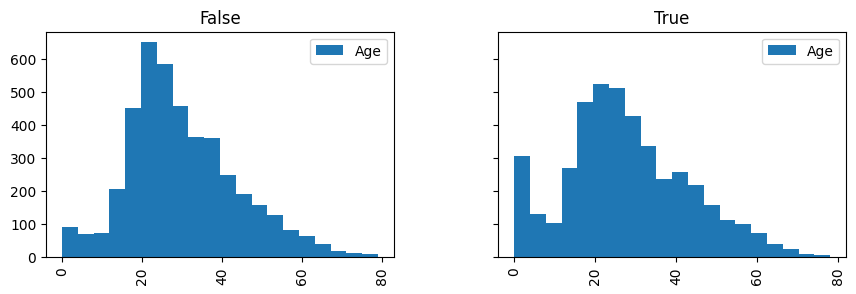

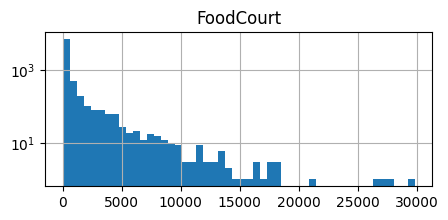

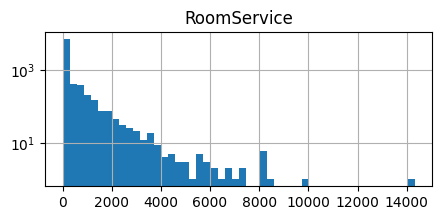

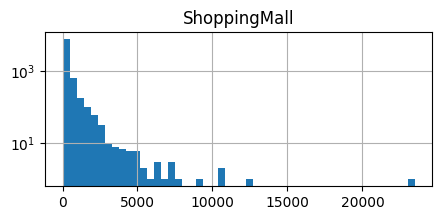

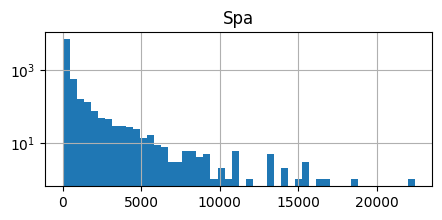

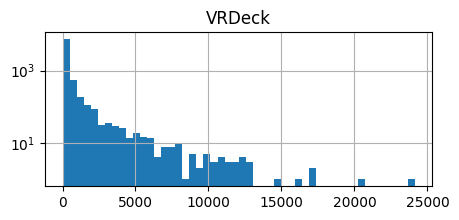

In [132]:
train_data_og.hist(column= ["Age"],by='Transported', bins =20, figsize=(10,3), legend=True, sharey=True) 
train_data_og.hist(column=["FoodCourt"], bins = 50, figsize=(5,2), log =True)
train_data_og.hist(column= ["RoomService"], bins = 50, figsize=(5,2),log =True)
train_data_og.hist(column= ["ShoppingMall"], bins = 50, figsize=(5,2),log =True)
train_data_og.hist(column= ["Spa"], bins = 50, figsize=(5,2),log =True)
train_data_og.hist(column= ["VRDeck"], bins = 50, figsize=(5,2), log = True)

maybe create Age bins: [0,12],[13,40],[41,80] 

In [48]:
print(train_data_og[['HomePlanet','Transported']].groupby(['HomePlanet'])['Transported'].mean())
print(train_data_og[['CryoSleep','Transported']].groupby(['CryoSleep'])['Transported'].mean())
print(train_data_og[['Destination','Transported']].groupby(['Destination'])['Transported'].mean())
print(train_data_og[['VIP','Transported']].groupby(['VIP'])['Transported'].mean())

HomePlanet
Earth     0.423946
Europa    0.658846
Mars      0.523024
Name: Transported, dtype: float64
CryoSleep
False    0.328921
True     0.817583
Name: Transported, dtype: float64
Destination
55 Cancri e      0.610000
PSO J318.5-22    0.503769
TRAPPIST-1e      0.471175
Name: Transported, dtype: float64
VIP
False    0.506332
True     0.381910
Name: Transported, dtype: float64


CryoSleep and VIP have good correlation to Transported

# Data Wrangling & Cleaning
* (DONE) Drop attribute:  PassengerId, Name  
* (DONE) Interpolate data using forward fill: HomePlanet, CryoSleep, Cabin, Destination, VIP
* (DONE) Interpolate data acc. to distribution: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
* (DONE) HomePlanet/Destination: Convert into numeric.
* (DONE) Cabin: Extract deck/num/side into different features  
* (DONE) PassengerId: Extract gggg_pp into different features  
* (X) Age: make it ordinal by breaking into bands  
* (X) Price: Combine all the services into one feature.  

interpolation can be done better, taking median is not a good idea. https://www.kaggle.com/competitions/spaceship-titanic/discussion/315987

In [134]:
print(train_data_og['Destination'].unique())
print(dataset['Age'].mean())

['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
28.65814620162446


In [215]:
train_data = train_data_og.copy()
test_data = test_data_og.copy()

combine = [train_data,test_data]

for dataset in combine:
    
    dataset.drop(columns=['Name'], axis=1, inplace=True)

    dataset['HomePlanet'] = dataset['HomePlanet'].fillna(method = 'ffill')
    dataset['Destination'] = dataset['Destination'].fillna(method = 'ffill')
    dataset['CryoSleep'] = dataset['CryoSleep'].fillna(method = 'ffill')
    dataset['VIP'] = dataset['VIP'].fillna(method = 'ffill')
    dataset['Age'] = dataset['Age'].fillna(value = dataset['Age'].mean())
    dataset['RoomService'] = dataset['RoomService'].fillna(value = dataset['RoomService'].median())
    dataset['FoodCourt'] = dataset['FoodCourt'].fillna(value = dataset['FoodCourt'].median())
    dataset['ShoppingMall'] = dataset['ShoppingMall'].fillna(value = dataset['ShoppingMall'].median())
    dataset['Spa'] = dataset['Spa'].fillna(value = dataset['Spa'].median())
    dataset['VRDeck'] = dataset['VRDeck'].fillna(value = dataset['VRDeck'].median())

    dataset['Cabin'] = dataset['Cabin'].fillna(method = 'ffill')
    cabin_split = dataset['Cabin'].str.split('/', n=-1, expand= True)
    dataset['Deck'] = cabin_split[0]
    dataset['Num'] = cabin_split[1].astype(int)
    dataset['Side'] = cabin_split[2]
    dataset.drop(columns=['Cabin'], axis=1, inplace=True)

    passengerid_split = dataset['PassengerId'].str.split('_', n = -1, expand = True) 
    dataset['Group'] = passengerid_split[0].astype(int)
    dataset['PassengerNo'] = passengerid_split[1].astype(int)
    dataset.drop(columns=['PassengerId'], axis=1, inplace=True)

    dataset['TotalBill'] = dataset['RoomService'] + dataset['FoodCourt'] + dataset['ShoppingMall'] + dataset ['Spa'] + dataset['VRDeck']

    dataset['HomePlanet'] = dataset['HomePlanet'].map({'Earth':1,'Europa':2, 'Mars':3})
    dataset['Destination'] = dataset['Destination'].map({'TRAPPIST-1e':1, 'PSO J318.5-22':2, '55 Cancri e':3})
    dataset['Deck'] = dataset['Deck'].map({'B':1, 'F':2, 'A':3, 'G':4, 'E':5, 'D':6, 'C':7, 'T':8})
    dataset['Side'] = dataset['Side'].map({'S':1, 'P':2})
    

# print(train_data.dtypes)
display(train_data.sample(n=5).style)
print(train_data.isnull().sum())







,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Num,Side,Group,PassengerNo,TotalBill
5551,1,False,1,33.000000,False,48.000000,94.000000,756.000000,308.000000,0.000000,False,2,1223,2,5920,1,1206.000000
2206,1,False,2,29.000000,False,0.000000,0.000000,792.000000,0.000000,0.000000,True,2,481,2,2361,2,792.000000
5713,3,True,1,28.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,True,2,1151,1,6054,1,0.000000
4458,1,False,1,22.000000,False,37.000000,3.000000,0.000000,305.000000,581.000000,True,4,773,1,4739,1,926.000000
6668,1,False,1,20.000000,False,0.000000,0.000000,2330.000000,120.000000,0.000000,True,2,1458,2,7029,1,2450.000000


HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Deck            0
Num             0
Side            0
Group           0
PassengerNo     0
TotalBill       0
dtype: int64


# Modeling

In [216]:
train_data = train_data.drop(columns=['Transported'],axis = 1)
print(train_data.shape, train_data_og.shape)

(8693, 16) (8693, 14)


In [217]:
train_features, test_features, train_labels, test_labels = train_test_split(train_data,train_data_og['Transported'], test_size = 0.2)

rf = RandomForestClassifier(n_estimators=500)

rf.fit(train_features,train_labels)

test_predictions = rf.predict(test_features)

print(f'Accuracy : {accuracy_score(test_labels, test_predictions)}')



Accuracy : 0.8050603795284647


Finally Running on Test.csv

In [209]:
rf_final = RandomForestClassifier(n_estimators=500)
rf_final.fit(train_data,train_data_og['Transported'])
final_predictions = rf_final.predict(test_data)
result = pd.DataFrame({"PassengerId":test_data_og['PassengerId'],
                        'Transported': final_predictions.astype(bool)})
result.to_csv('./final_submission.csv',index=False)
# gives 0.79611 score

Hyperparameter Tuning


In [ ]:
param_grid = {'n_estimators':[100,200,500,800],
                'max_depth': [5,10,15],
                'criterion': ['gini','entropy','log_loss']}

rf = RandomForestClassifier()
rf_CV = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5)

rf_CV.fit(train_features,train_labels)

rf_CV.best_params_


In [219]:
rf_final = RandomForestClassifier(criterion= 'log_loss', max_depth= 15, n_estimators= 100)
rf_final.fit(train_data,train_data_og['Transported'])
final_predictions = rf_final.predict(test_data)
result = pd.DataFrame({"PassengerId":test_data_og['PassengerId'],
                        'Transported': final_predictions.astype(bool)})
result.to_csv('./final_submission.csv',index=False)
# gives 0.79728 score

Lazy Prediction:


In [210]:
lazy_classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=False, random_state=42, classifiers='all')

models, lazy_predictions = lazy_classifier.fit(train_features, test_features, train_labels, test_labels)
print(models)

  7%|▋         | 2/29 [00:00<00:13,  2.05it/s]e:\Coding prac\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
e:\Coding prac\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
e:\Coding prac\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
e:\Coding prac\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
e:\Coding prac\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
 38%|███▊      | 11/29 [00:04<00:06,  2.71it/s]e:\Coding prac\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:227: RuntimeWarnin

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
ExtraTreesClassifier               0.80               0.80     0.80      0.80   
LGBMClassifier                     0.80               0.80     0.80      0.80   
SVC                                0.80               0.80     0.80      0.80   
XGBClassifier                      0.79               0.79     0.79      0.79   
RandomForestClassifier             0.79               0.79     0.79      0.79   
NuSVC                              0.79               0.79     0.79      0.79   
BaggingClassifier                  0.78               0.78     0.78      0.78   
AdaBoostClassifier                 0.78               0.78     0.78      0.78   
SGDClassifier                      0.77               0.77     0.77      0.77   
LogisticRegression                 0.77               0.77     0.77      0.77   
LinearSVC                   

Using Light Gradient Boosting Machine (LGBM classifier) model 

In [220]:
param_grid = {'n_estimators':[40,60,80],
                'max_depth': [-1,10,12,15],
                'learning_rate': [0.1,0.15,0.2],
                'objective': ['binary']}

lg = lgbm.LGBMClassifier()
lg_CV = GridSearchCV(estimator = lg, param_grid = param_grid, cv = 5)

lg_CV.fit(train_features,train_labels)

lg_CV.best_params_

{'learning_rate': 0.1,
 'max_depth': -1,
 'n_estimators': 80,
 'objective': 'binary'}

In [221]:
lg_final = lgbm.LGBMClassifier( learning_rate = 0.1,
                            max_depth = -1,
                            n_estimators = 80,
                            objective = 'binary')
lg_final.fit(train_features, train_labels)
test_predictions = lg_final.predict(test_features)

print(f'Accuracy : {accuracy_score(test_labels, test_predictions)}')


Accuracy : 0.8125359401955147


In [222]:
lg_final.fit(train_data,train_data_og['Transported'])
final_predictions = lg_final.predict(test_data)
result = pd.DataFrame({"PassengerId":test_data_og['PassengerId'],
                        'Transported': final_predictions.astype(bool)})
result.to_csv('./final_submission.csv',index=False)
# score is 0.80593

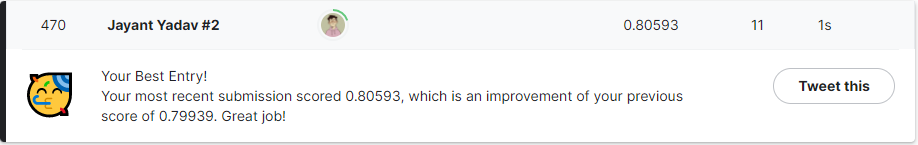